In [ ]:
import os
import re
from tqdm import tqdm
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Dropout, LSTM, Embedding, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import TensorBoard
from sklearn.model_selection import train_test_split
from keras.layers import Embedding
from  keras . utils  import  to_categorical
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D,Conv2D, MaxPooling1D, Embedding, Flatten
from keras.models import Model
from keras.initializers import Constant
from keras.layers import Embedding


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import pandas as pd 
train_data=pd.read_csv('gdrive/My Drive/Colab Notebooks/ulm_train.csv')
stopwords=pd.read_csv('gdrive/My Drive/Colab Notebooks/Stopwords.csv')
test_data=pd.read_csv('gdrive/My Drive/Colab Notebooks/ulm_test.csv')


In [ ]:
train_data.head

<bound method NDFrame.head of      label                                               text  is_valid
0       fe  সাম্প্রদায়িক সংঘাত ও মানবিক প্রতিরোধ সাম্প্রদা...     False
1       ij  আজ মাও সেতুং-এর জন্মদিন। মাও সে তুং। বারবার ইত...     False
2       mk  গোলাম আযমের বিরুদ্ধে অভিযোগ ৬১ টি, যেকোনো ১ টি...     False
3       rn  জলের সন্তরন- (এক) অনেক গুলো সাপ মিজানের শরীরের...     False
4       hm  খুবরগুড়ে . . . এইভাবে হতে থাকে ক্রমাগত কেউ মার...     False
...    ...                                                ...       ...
1795    rn  রহস্যময় বিতর্কিত পুরুষ রাসপুতিন ইতিহাস কি শুধু...     False
1796    fe  রাজনৈতিক মূর্খতা ও মুক্তিযুদ্ধের মৌলিক ফসল রাজ...     False
1797    mk  ইউপি ইলেকশন এবং ___ বাংলাদেশের তিন স্তরবিশিষ্ট...     False
1798    rn  মনে করি, A হলো একটি সফল জীবন। A=x+y+z, এখানে x...     False
1799    fe  বহির্বিশ্বে বাংলা সাহিত্য-সংস্কৃতির বীজ ও বীক্...     False

[1800 rows x 3 columns]>

In [ ]:
!git clone -l -s https://github.com/banglakit/bengali-stemmer.git

Cloning into 'bengali-stemmer'...
remote: Enumerating objects: 25, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 94 (delta 5), reused 16 (delta 4), pack-reused 69
Unpacking objects: 100% (94/94), done.


In [ ]:
!pip install git+https://github.com/banglakit/bengali-stemmer.git    

  Cloning https://github.com/banglakit/bengali-stemmer.git to /tmp/pip-req-build-882uyl_d
  Running command git clone -q https://github.com/banglakit/bengali-stemmer.git /tmp/pip-req-build-882uyl_d
  Created wheel for bengali-stemmer: filename=bengali_stemmer-0.0.1-py2.py3-none-any.whl size=6393 sha256=d2fa9b23099d82fdd992f21d5ae4ca8c1859105671f7f2918f090a90cd072ed7
  Stored in directory: /tmp/pip-ephem-wheel-cache-xhnbzgvk/wheels/a1/ad/a1/4ba354059b17c00600a14e13a504e7bdb49f20f2f4e2f3639c
Successfully built bengali-stemmer


In [ ]:
from bengali_stemmer.rafikamal2014 import RafiStemmer
stemmer = RafiStemmer()
stemmer.stem_word('বাংলায়')

'বাংলা'

In [ ]:
total_data = train_data
total_data=total_data.append(test_data, ignore_index = True)

In [ ]:
macronum=sorted(set(total_data['label']))
macro_to_id = dict((note, number) for number, note in enumerate(macronum))

def fun(i):
    return macro_to_id[i]

total_data['label']=total_data['label'].apply(fun)


In [ ]:
texts = list(total_data['text'])
labels = list(total_data['label'])

In [ ]:
def clean_punct(sentence):
    cleaned = re.sub(r'[?|!|\'|"|#|।|’|‘]', r'', sentence)
    cleaned1 = re.sub(r'[.|,|(|)|\|/]', r'', cleaned)
    cleaned = re.sub(r'[০|১|২|৩|৪|৫|৬|৭|৮|৯]', r'', cleaned1)
    cleaned1 = re.sub(r'[-|=]', r' ', cleaned)
    return cleaned1

In [ ]:
set_stop = set(stopwords['words'])

In [ ]:

def pre_process(data):
    i=0
    str1=' '
    final_string = []
    final_words = []
    all_negative_words = []
    s=''

    for sentence in data:
        filtered_sentence = []

        for w in sentence.split():
            for cleaned_word in clean_punct(w).split():
                if len(cleaned_word)>2:
                    if((cleaned_word) not in set_stop):
                        s = stemmer.stem_word(cleaned_word)
                        if len(s)>2:
                            final_words.append(s)
                            filtered_sentence.append(s)
                    else:
                        continue
                else:
                    continue

        str1 = " ".join(filtered_sentence)
        final_string.append(str1)
    return final_string

In [ ]:
texts = pre_process(texts)

In [ ]:
texts[0]

'সাম্প্রদায়িক সংঘাত মানবিক প্রতিরোধ সাম্প্রদায়িক সংঘাত মানবিক প্রতিরোধফকির ইলিয়াস দেশ থাকি বহুজাতিক বহুভাষিক মানুষ বাস ধর্মাবলম্বী মতাবলম্বী মানুষ কারো কারো মিল চাইল সামান্য বিষ প্রতিদিন দাঙ্গা তেমন হ্যাঁ প্রি পাঠক মার্কিন যুক্তরাষ্ট্র কথা বলছিএ দেশ মানুষ মানুষ বুক পাঁজর চিবি দেশ কঠোর আইন থাক পার পারব পারব কঠিন শাস্তির মুখোমুখি জীবনবাজি রায়ট কেপাক ভারত উপমহাদেশ জন্ম বিভক্ত রায়ট মধ্য কারোর অজানা জন্মইতিহাস জন্ম পাকিস্তান ভারত পরবর্তীকাল বাংলাদেশ ভূখণ্ড দ্বিজাতি তত্ত্ব শত্রু সম্পত্তি আইন মানুষ মানুষ ধর্ম বিভাজন সেভাব পরিকল্পিতভাব সাল ভারত ভাগ অসংখ্য হিন্দু ঘরবাড়ি ছেড় গিয় জিন্নাহর দ্বিজাতি তত্ত্ব ভিত্তি ওঠা দেশ অস্তিত্ব রক্ষা প্রশ্ন প্রথম সাল পূর্বতন পূর্ব পাকিস্তান সাম্প্রদায়িক দাঙ্গ হিন্দু নিরাপত্ত পালি সাল হিন্দু আওয়ামী লীগ ভোট বিশ্বাস দখলদ পাক সেনা সহযোগী প্রবল প্রতিশোধস্পৃহা খুঁজ খুঁজ হিন্দু নিধন চালি হিন্দু বুদ্ধিজীবী সমাজসেবী শ্রদ্ধে ব্যক্তিত্ব ঢাকা বিশ্ববিদ্যালয় জগন্নাথ সহস্রাধিক হিন্দু ছাত্র হত্যা সাল নভেম্বর তারিখ ইউএস সিনেট কমি প্রামাণ্য প্রতিবেদন সিনেটর এডওয়ার্ড কেনেডি লিখ “সব

In [ ]:
def load_data(num_words, sequence_length, test_size=0.25, oov_token=None):
    tokenizer = Tokenizer(num_words=num_words, oov_token=oov_token)
    num_classes=6
    y = to_categorical(np.asarray(labels), num_classes)
    tokenizer.fit_on_texts(texts)
    X = tokenizer.texts_to_sequences(texts)
    X = np.array(X)
    # pad sequences with 0's
    X = pad_sequences(X, maxlen=sequence_length)
    # split data to training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1)
    data = {}
    data["X_train"] = X_train
    data["X_test"]= X_test
    data["y_train"] = y_train
    data["y_test"] = y_test
    data["tokenizer"] = tokenizer
    return data

In [ ]:
# bn_glove = pd.read_csv('gdrive/My Drive/Colab Notebooks/GloVe-Bengali-master.csv')

In [ ]:
# train_data=pd.read_csv('gdrive/My Drive/Colab Notebooks/ulm_train.csv')

def get_embedding_vectors(word_index, embedding_size=100):
    
    embedding_matrix = np.zeros((len(word_index) + 1, embedding_size))
    with open(f"gdrive/My Drive/Colab Notebooks/bn_glove.{embedding_size}d.txt", encoding="utf8") as f:
        for line in tqdm(f, "Reading GloVe"):
            values = line.split()
            # get the word as the first word in the line
            word = values[0]
            if word in word_index:
                idx = word_index[word]
                # get the vectors as the remaining values in the line
                embedding_matrix[idx] = np.array(values[1:], dtype="float32")
    return embedding_matrix

In [ ]:
MAX_SEQUENCE_LENGTH = 11276    #max([len(s.split()) for s in texts]) 
MAX_NUM_WORDS = 109804
vocab_size = MAX_NUM_WORDS
EMBEDDING_DIM = 300
VALIDATION_SPLIT = 0.2

data = load_data(MAX_NUM_WORDS , MAX_SEQUENCE_LENGTH,VALIDATION_SPLIT)

In [ ]:
len(data['tokenizer'].word_index)

109803

In [ ]:
embedding_matrix = get_embedding_vectors( data['tokenizer'].word_index ,EMBEDDING_DIM )

Reading GloVe: 134256it [00:05, 22646.32it/s]


In [ ]:
data['X_train'].shape

(1680, 11276)

In [ ]:
data['y_train'].shape

(1680, 6)

In [ ]:
data['y_train'][0]

array([0., 0., 0., 0., 0., 1.], dtype=float32)

In [ ]:
embedding_layer = Embedding(len(data['tokenizer'].word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

In [ ]:



print('Training model.')

# train a 1D convnet with global maxpooling
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(128, 5, activation='relu')(embedded_sequences)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(35)(x)  # global max pooling
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
preds = Dense(6, activation='softmax')(x)

model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',   # using 'rmsprop' optimizer
              metrics=['acc'])

Training model.


In [ ]:
model.fit(data['X_train'], data['y_train'], validation_data=(data['X_test'], data['y_test']),
          epochs=5, batch_size=128)

Epoch 1/5
14/14 [==============================] - 352s 25s/step - loss: 1.7519 - acc: 0.2357 - val_loss: 1.6536 - val_acc: 0.3524
Epoch 2/5
14/14 [==============================] - 350s 25s/step - loss: 1.6170 - acc: 0.3286 - val_loss: 1.5854 - val_acc: 0.3500
Epoch 3/5
14/14 [==============================] - 350s 25s/step - loss: 1.5781 - acc: 0.3369 - val_loss: 1.6611 - val_acc: 0.3214
Epoch 4/5
14/14 [==============================] - 352s 25s/step - loss: 1.5278 - acc: 0.3565 - val_loss: 1.7152 - val_acc: 0.2714
Epoch 5/5
14/14 [==============================] - 351s 25s/step - loss: 1.5042 - acc: 0.3798 - val_loss: 1.5051 - val_acc: 0.3690


In [ ]:
# create the embedding layer
embedding_layer = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=False)


In [ ]:
# define model
model = Sequential()
model.add(embedding_layer)
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(6, activation='softmax'))
print(model.summary())


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 11276, 300)        32941200  
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 11272, 128)        192128    
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 5636, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 721408)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 4328454   
Total params: 37,461,782
Trainable params: 4,520,582
Non-trainable params: 32,941,200
_________________________________________________________________
None


In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) # using adma optimizer


In [ ]:
# fit network
model.fit(data['X_train'], data['y_train'], epochs=10, verbose=2)
# evaluate
loss, acc = model.evaluate(data['X_test'], data['y_test'], verbose=0)
print('Test Accuracy: %f' % (acc*100))

Epoch 1/10
53/53 - 300s - loss: 1.8651 - accuracy: 0.3571
Epoch 2/10
53/53 - 301s - loss: 0.8687 - accuracy: 0.7179
Epoch 3/10
53/53 - 301s - loss: 0.3441 - accuracy: 0.9054
Epoch 4/10
53/53 - 302s - loss: 0.1174 - accuracy: 0.9810
Epoch 5/10
53/53 - 299s - loss: 0.0388 - accuracy: 0.9970
Epoch 6/10
53/53 - 301s - loss: 0.0159 - accuracy: 0.9994
Epoch 7/10
53/53 - 299s - loss: 0.0088 - accuracy: 0.9994
Epoch 8/10
53/53 - 298s - loss: 0.0064 - accuracy: 0.9994
Epoch 9/10
53/53 - 300s - loss: 0.0050 - accuracy: 0.9994
Epoch 10/10
53/53 - 299s - loss: 0.0041 - accuracy: 0.9994
Test Accuracy: 79.047620


In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
def confussion_mat(model):
    # Predict the values from the validation dataset
    Y_pred = model.predict(data['X_test'])
    # Convert predictions classes to one hot vectors 
    Y_pred_classes = np.argmax(Y_pred,axis = 1) 
    # Convert validation observations to one hot vectors
    Y_true = np.argmax(data['y_test'],axis = 1) 
    # compute the confusion matrix
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    # plot the confusion matrix
    f,ax = plt.subplots(figsize=(8, 8))
    sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

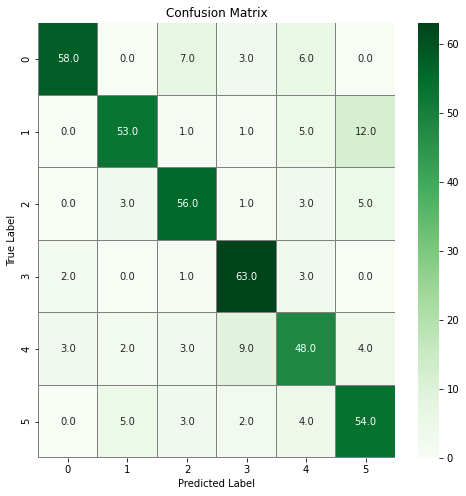

In [ ]:
confussion_mat(model)

In [ ]:
model = Sequential()
model.add(embedding_layer)
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.25)) # here using 'dropout' 
model.add(Flatten())
model.add(Dense(6, activation='softmax'))
print(model.summary())


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 11276, 300)        32941200  
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 11272, 128)        192128    
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 5636, 128)         0         
_________________________________________________________________
dropout (Dropout)            (None, 5636, 128)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 721408)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 4328454   
Total params: 37,461,782
Trainable params: 4,520,582
Non-trainable params: 32,941,200
__________________________________

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [ ]:
history = model.fit(data['X_train'], data['y_train'], validation_data=(data['X_test'], data['y_test']), epochs=10, verbose=2)

Epoch 1/10
53/53 - 341s - loss: 1.6368 - accuracy: 0.3923 - val_loss: 1.1448 - val_accuracy: 0.5929
Epoch 2/10
53/53 - 343s - loss: 0.6590 - accuracy: 0.7869 - val_loss: 0.7353 - val_accuracy: 0.7643
Epoch 3/10
53/53 - 345s - loss: 0.2008 - accuracy: 0.9500 - val_loss: 0.7412 - val_accuracy: 0.7714
Epoch 4/10
53/53 - 345s - loss: 0.0545 - accuracy: 0.9940 - val_loss: 0.7411 - val_accuracy: 0.7857
Epoch 5/10
53/53 - 344s - loss: 0.0218 - accuracy: 0.9982 - val_loss: 0.7876 - val_accuracy: 0.7810
Epoch 6/10
53/53 - 345s - loss: 0.0105 - accuracy: 0.9994 - val_loss: 0.7968 - val_accuracy: 0.7786
Epoch 7/10
53/53 - 344s - loss: 0.0069 - accuracy: 0.9994 - val_loss: 0.8494 - val_accuracy: 0.7810
Epoch 8/10
53/53 - 344s - loss: 0.0051 - accuracy: 0.9994 - val_loss: 0.8365 - val_accuracy: 0.7857
Epoch 9/10
53/53 - 344s - loss: 0.0044 - accuracy: 1.0000 - val_loss: 0.8674 - val_accuracy: 0.7929
Epoch 10/10
53/53 - 344s - loss: 0.0038 - accuracy: 0.9994 - val_loss: 0.8984 - val_accuracy: 0.8000

In [ ]:
def history2(history):
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


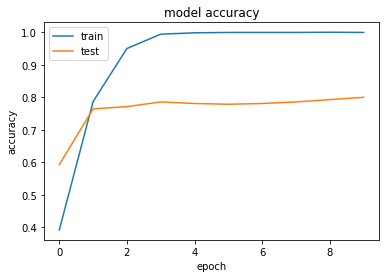

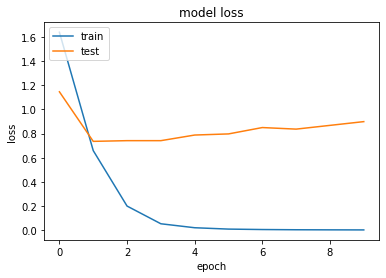

In [ ]:
history2(history)

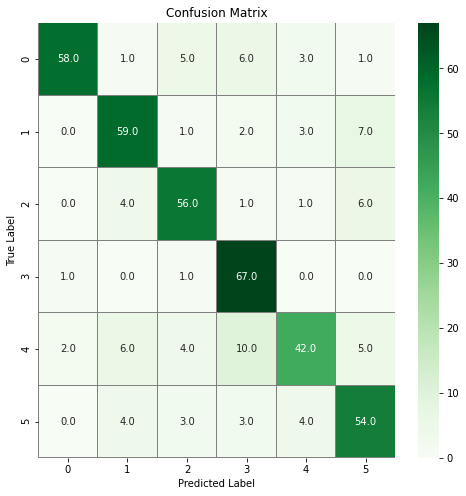

In [ ]:
confussion_mat(model)